In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [30]:
file = open("./dataset/scatter_ds1.d")

In [31]:
data = []
label = []
for line in file:
    line = line.strip().split(' ')
    data.append([float(line[0]),float(line[1])])
    label.append(int(line[2]))

In [32]:
data = np.array(data)
label = np.array(label)

In [33]:
print(data.shape)
print(label.shape)

(300, 2)
(300,)


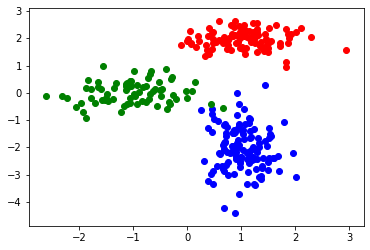

In [41]:
plt.figure()
for i in range(len(data)):
    if label[i] == 0:      
        plt.scatter(data[i,0],data[i,1],color='r')
    if label[i] == 1:
        plt.scatter(data[i,0],data[i,1],color='b')
    if label[i] == 2:
        plt.scatter(data[i,0],data[i,1],color='g')

In [183]:
file = open('./dataset/simil_ds1.d')

mat_simil = []

for line in file:
    line = line.strip().split(' ')
    mat_simil.append(list(float(line[i]) for i in range(len(line))))

mat_simil = np.array(mat_simil)

In [185]:
print(mat_simil.shape)

(300, 300)


In [467]:
class clustering:
    
    def __init__(self,simil,T,N_c,ε):
        
        self.simil = simil
        self.T = T
        self.N_c = N_c
        self.ε = ε
        
        '''initialize'''
        
        self.N = simil.shape[0]
        self.m = 0
        
        self.P_i = 1/self.N
        self.P_c = np.zeros(self.N_c)
        self.P_ci = np.zeros((self.N,self.N_c))
        self.P_ic = np.zeros((self.N_c,self.N))
        
        self.S_c = np.zeros(self.N_c)
        self.S_ci = np.zeros((self.N,self.N_c))

        for i in range(N): 
            r_list = np.array(list(np.random.random() for _ in range(self.N_c)))
            r_list = r_list/sum(r_list)
            self.P_ci[i] = r_list
            
        self.update_value()
        
        
    def fit(self):
        
        P_ci_new = np.zeros((self.N,self.N_c))
        
        stop = 0
        
        while stop == 0:
            for i in range(self.N):
                for c in range(self.N_c):
                    P_ci_new[i][c] = self.P_c[c]*np.exp(1/self.T * (2*self.S_ci[i][c] - self.S_c[c]))
                P_ci_new[i] = P_ci_new[i]/sum(P_ci_new[i])
                
                
            self.m += 1
            stop = 1
            for i in range(self.N):
                for c in range(self.N_c):
                    if abs(P_ci_new[i][c] - self.P_ci[i][c]) > self.ε:
                        stop = 0
                        continue

            for i in range(self.N):
                for c in range(self.N_c):
                    self.P_ci[i][c] = P_ci_new[i][c]

            self.update_value()
        
        print("Iteration times:",self.m)
    
    
    def predict(self):
        
        predict_label = list(np.argmax(self.P_ci[i]) for i in range(self.N))
        
        predict_s = self.P_c.T @ self.S_c
        
        return predict_label, predict_s

        
    def update_value(self):
            
        '''compute P(C)'''
        
        for c in range(self.N_c):
            self.P_c[c] = sum(self.P_ci[:,c]) * P_i
        
        '''compute P(i|C)'''

        for i in range(self.N_c):
            for j in range(N):
                self.P_ic[i][j] = self.P_ci[j][i]*self.P_i / self.P_c[i]

        '''compute S(C)'''

        for c in range(self.N_c):
            for i in range(self.N):
                for j in range(self.N):
                    self.S_c[c] += self.P_ic[c][i]*self.P_ic[c][j]*self.simil[i][j]

        '''compute S(C;i)'''

        for c in range(self.N_c):
            for i in range(self.N):
                for j in range(self.N):
                    self.S_ci[i][c] += self.P_ic[c][j]*self.simil[i][j]


In [468]:
cluster = clustering(mat_simil,1,3,0.01)

In [469]:
cluster.fit()

Iteration times: 17


In [470]:
predict_label,predict_s = cluster.predict()

In [471]:
print(predict_s)

-23.696533872318014


In [472]:
def visualize(data,label,N_c):

    clusters = [[] for _ in range(N_c)]
    
    N = data.shape[0]
    for i in range(N):
        for c in range(N_c):
            if label[i] == c:
                clusters[c].append(data[i])
                
    plt.figure()
    colors = 'rgbycm'
    for c in range(N_c):
        clusters[c] = np.array(clusters[c])
        plt.scatter(clusters[c][:,0],clusters[c][:,1],c=colors[c])
    

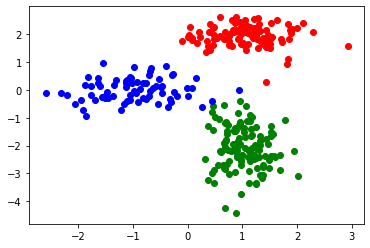

In [473]:
visualize(data,predict_label,3)

In [464]:
file = open('./dataset/simil_ds2.d')

mat_simil1 = []

for line in file:
    line = line.strip().split(' ')
    mat_simil1.append(list(float(line[i]) for i in range(len(line))))

mat_simil1 = np.array(mat_simil1)

In [465]:
s_list = []
for c in range(2,10):
    cluster = clustering(mat_simil1,1,c,0.01)
    cluster.fit()
    _,predict_s = cluster.predict()
    s_list.append(predict_s)

In [466]:
'''Selon le resultat, 5 clusters sont présents'''
print(s_list)

[-203.71631764322282, -68.73956208831653, -49.36670217920116, -29.992310275842414, -71.63691182102991, -120.28007003541634, -94.65823976639516, -114.95753600440412]


In [488]:
fileSP_data = open('./dataset/SP500/sp500_data.d')
fileSP_matType = open('./dataset/SP500/sp500_matType.d')

dataSP_data = []
dataSP_matType = []

for line in fileSP_data:
    line = line.strip().split(' ')
    dataSP_data.append(list(float(line[i]) for i in range(len(line))))
    
for line in fileSP_matType:
    line = line.strip().split(' ')
    dataSP_matType.append(list(float(line[i]) for i in range(len(line))))
    
dataSP_data = np.array(dataSP_data)
dataSP_matType = np.array(dataSP_matType)

In [549]:
print(dataSP_data.shape)
print(dataSP_matType.shape)

(501, 273)
(501, 208)


In [563]:
M = dataSP_data.shape[1]

In [564]:
min_list = [min(dataSP_data[i]) for i in range(M)]
max_list = [max(dataSP_data[i]) for i in range(M)]

In [565]:
min_v = min(min_list)
max_v = max(max_list)
print(min_v)
print(max_v)

-0.28923
0.34775


In [566]:
P_ei = np.zeros(M)
def P_e(e, e_list):
    
    P = 0
    for i in range(M):
        P += 1 if e == e_list[i] else 0
    
    return P/M     

In [567]:
print(P_ei.shape)
print(dataSP_matType[1].size)

(273,)
208


In [568]:
def P_e1_e2(e1,e2,e1_list,e2_list):
    
    P = 0
    for i in range(e1_list.size):
        P += (1 if e1 == e1_list[i] else 0) * (1 if e2 == e2_list[i] else 0)
        
    return P/M 

In [569]:
delta = 10**(-7)

In [576]:
s = 0
i = min_v-delta
j = min_v-delta
while i < max_v+delta:
    while j <max_v+delta:
        
        s += P_e1_e2(i,j,dataSP_data[0],dataSP_data[1]) * np.log2(P_e1_e2(i,j,dataSP_data[0],dataSP_data[1])/(P_e(i, dataSP_data[0])*P_e(j, dataSP_data[1])+delta))
        i += delta
        j += delta
        
    print(s)


/home/jiangnan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys
/home/jiangnan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


KeyboardInterrupt: 